In [1]:

import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

sns.set(font_scale=1.3)
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download('wordnet')

import pickle
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import os
import nltk
import zipfile
import requests
from io import BytesIO

# Define the NLTK data directory in Kaggle
nltk_data_dir = "/kaggle/working/nltk_data"

# Ensure the directory exists
os.makedirs(nltk_data_dir, exist_ok=True)

# Download WordNet manually
wordnet_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/wordnet.zip"
response = requests.get(wordnet_url)
with zipfile.ZipFile(BytesIO(response.content), "r") as z:
    z.extractall(os.path.join(nltk_data_dir, "corpora"))

# Set NLTK data path
nltk.data.path.append(nltk_data_dir)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [4]:
df=pd.read_csv('/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv')

In [5]:
df.shape

(162980, 2)

In [6]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [7]:
df.dropna(axis=0, inplace=True)

In [8]:
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

In [9]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive
...,...,...
162975,why these 456 crores paid neerav modi not reco...,Negative
162976,dear rss terrorist payal gawar what about modi...,Negative
162977,did you cover her interaction forum where she ...,Neutral
162978,there big project came into india modi dream p...,Neutral


In [10]:
df=df.reset_index(drop=True)

In [11]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive
...,...,...
162964,why these 456 crores paid neerav modi not reco...,Negative
162965,dear rss terrorist payal gawar what about modi...,Negative
162966,did you cover her interaction forum where she ...,Neutral
162967,there big project came into india modi dream p...,Neutral


<Axes: xlabel='category'>

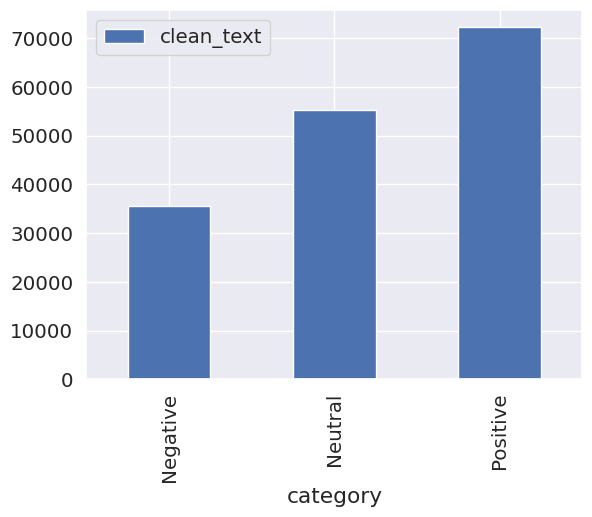

In [12]:
df.groupby('category').count().plot(kind='bar')

In [13]:
df['category'].value_counts()

category
Positive    72249
Neutral     55211
Negative    35509
Name: count, dtype: int64

<Axes: >

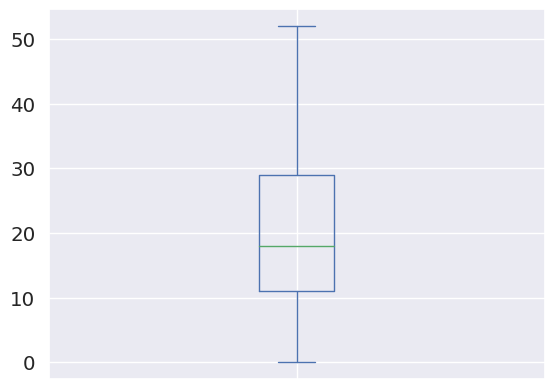

In [14]:
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


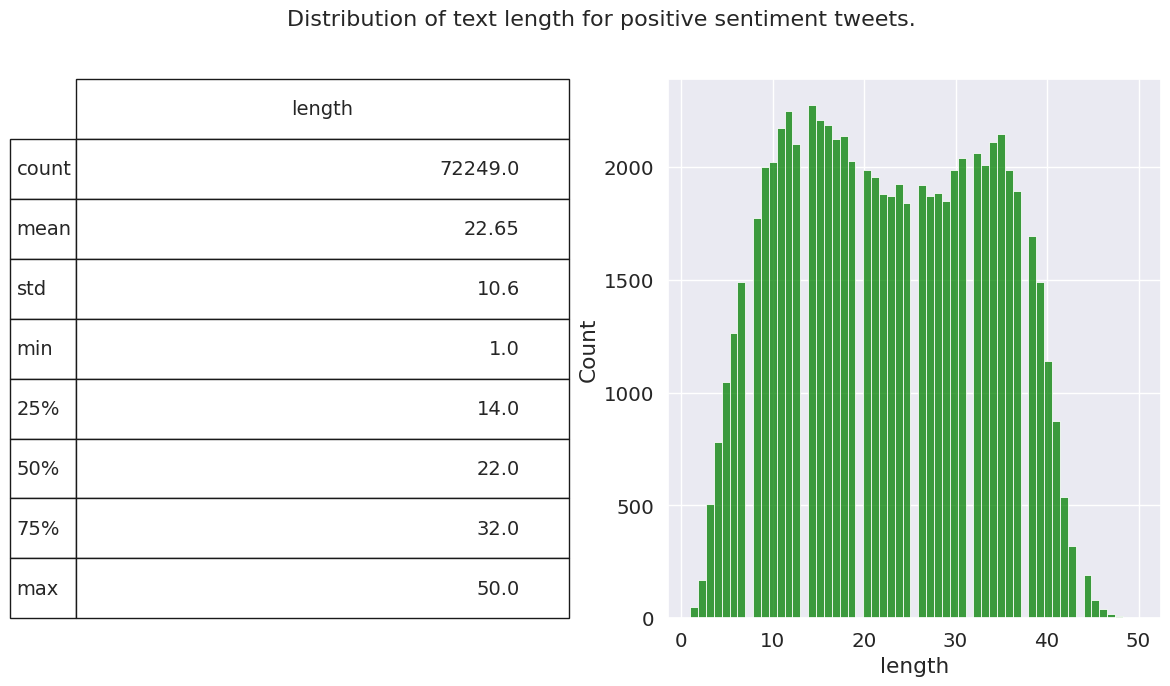

In [15]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


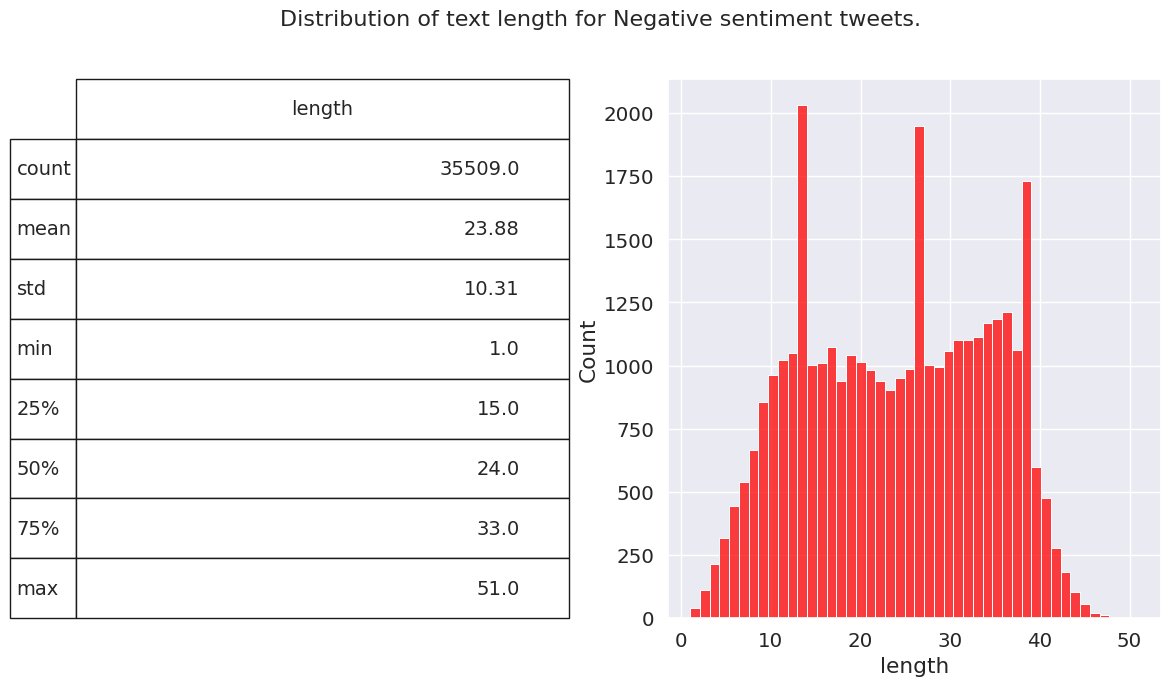

In [16]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


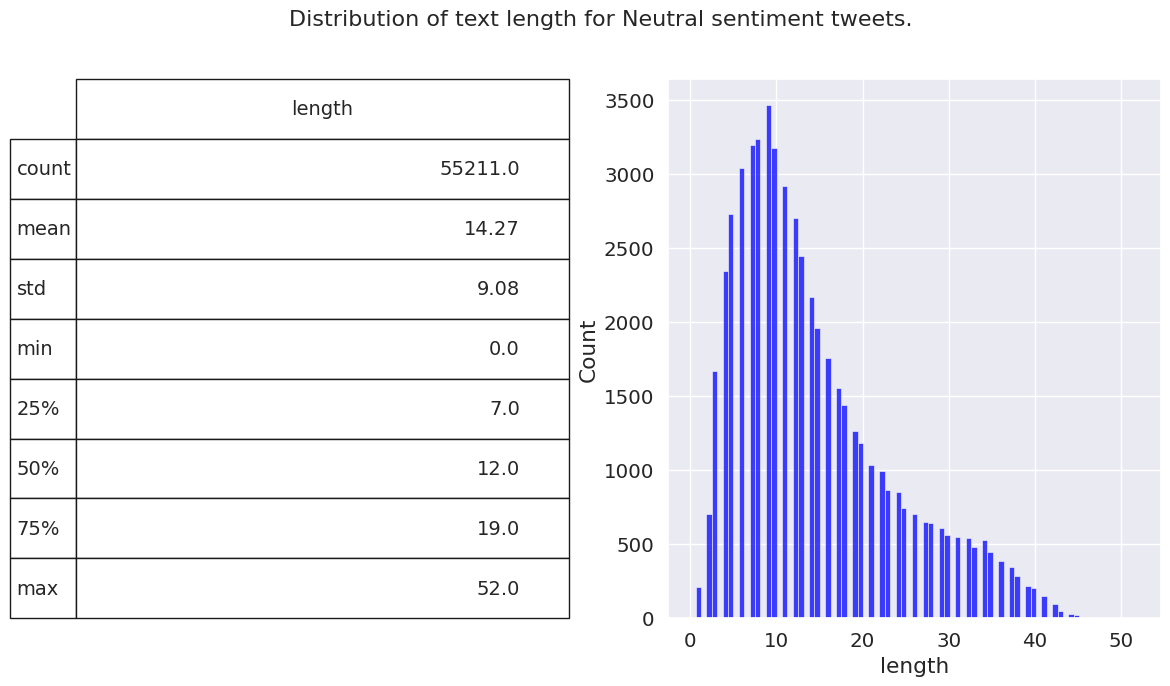

In [17]:
fig = plt.figure(figsize=(14,7))

# Compute text length
df['length'] = df.clean_text.str.split().apply(len)

# Plot histogram for Neutral category
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Neutral']['length'], ax=ax1, color='blue')

# Summary statistics
describe = df.length[df.category=='Neutral'].describe().to_frame().round(2)

# Create table
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText=describe.values, rowLabels=describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)

# Title
fig.suptitle('Distribution of text length for Neutral sentiment tweets.', fontsize=16)

plt.show()

In [18]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [19]:
df

,clean_text,category,length
0,when modi promised “minimum government maximum...,Negative,33
1,talk all the nonsense and continue all the dra...,Neutral,13
2,what did just say vote for modi welcome bjp t...,Positive,22
3,asking his supporters prefix chowkidar their n...,Positive,34
4,answer who among these the most powerful world...,Positive,14
...,...,...,...
162964,why these 456 crores paid neerav modi not reco...,Negative,18
162965,dear rss terrorist payal gawar what about modi...,Negative,36
162966,did you cover her interaction forum where she ...,Neutral,9
162967,there big project came into india modi dream p...,Neutral,13


In [20]:
df.drop(['length'], axis=1, inplace=True)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


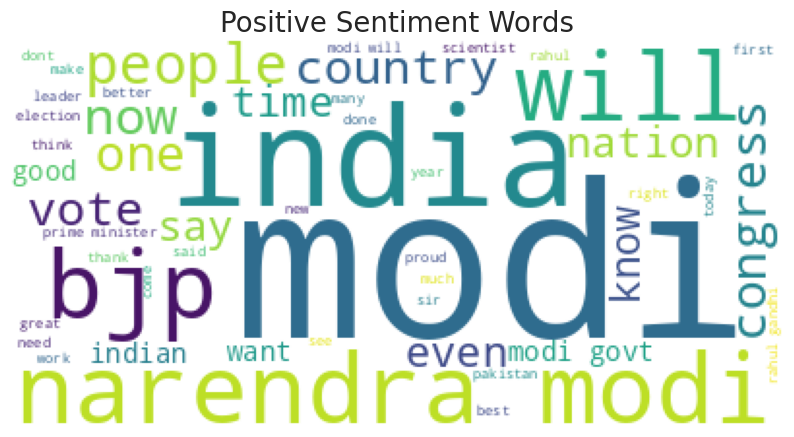

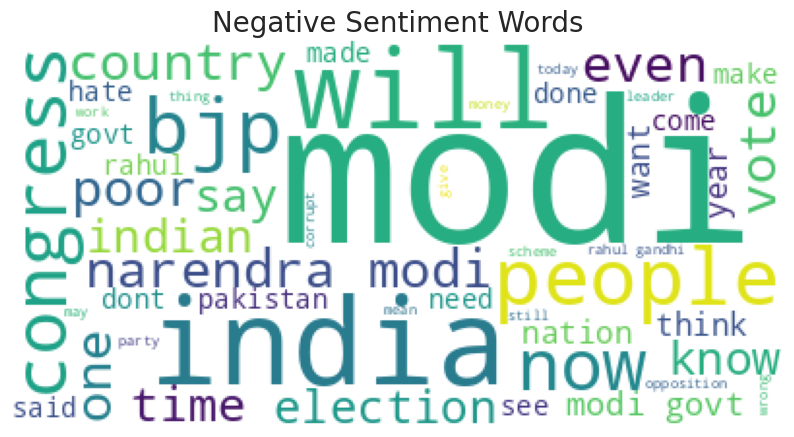

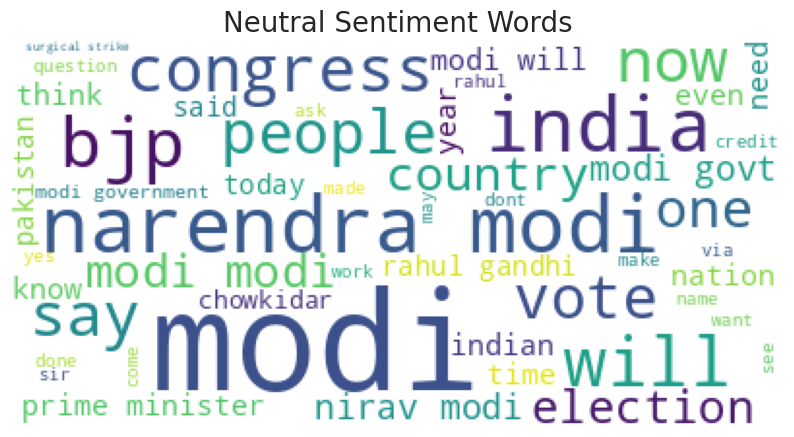

In [21]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
     
# Negative tweet words
wordcount_gen(df, 'Negative')
     
# Neutral tweet words
wordcount_gen(df, 'Neutral')

In [22]:
from nltk.stem import PorterStemmer
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [23]:
X = list(map(tweet_to_words, df['clean_text']))

In [24]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [25]:
print(X[10])
print(Y[10])

['thing', 'like', 'demonetis', 'gst', 'good', 'servic', 'tax', 'upper', 'cast', 'would', 'sort', 'either', 'view', 'favour', 'say', 'need', 'give', 'time', 'cast', 'like', 'dalit', 'muslim', 'modi', 'constituency2']
2


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [37]:
from sklearn.model_selection import train_test_split

# One-hot encode labels
y = pd.get_dummies(df['category'])

# Split into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

y_train = y_train.to_numpy().astype('float32')
y_val = y_val.to_numpy().astype('float32')
y_test = y_test.to_numpy().astype('float32')

# Final shape check
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (97781, 50) (97781, 3)
Validation Set -> (32594, 50) (32594, 3)
Test Set -> (32594, 50) (32594, 3)


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000

count_vector = CountVectorizer(
    max_features=vocabulary_size,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x
) 

X_train = count_vector.fit_transform(X_train).toarray()
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [29]:
print(count_vector.get_feature_names_out()[0:200])

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]


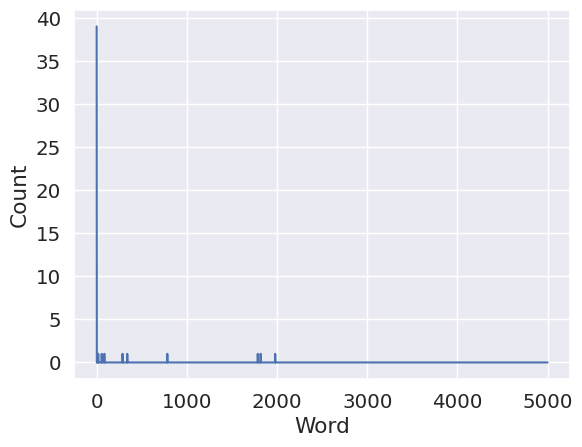

In [30]:
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [31]:
import pickle

# saving
with open('/kaggle/working/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('/kaggle/working/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [32]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"X_val shape: {X_val.shape}, dtype: {X_val.dtype}")
print(f"y_val shape: {y_val.shape}, dtype: {y_val.dtype}")

X_train shape: (97781, 5000), dtype: int64
y_train shape: (97781, 3), dtype: float32
X_val shape: (32594, 50), dtype: int32
y_val shape: (32594, 3), dtype: float32


In [33]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [38]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Hyperparameters
vocab_size = 5000
embedding_size = 64
max_len = 50
epochs = 17
batch_size = 64
learning_rate = 0.001

# Model definition
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

# Compile the model (use categorical_crossentropy since labels are one-hot)
model.build(input_shape=(None, max_len))
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 50, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 25, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,011 (1.31 MB)

 Trainable params: 343,011 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

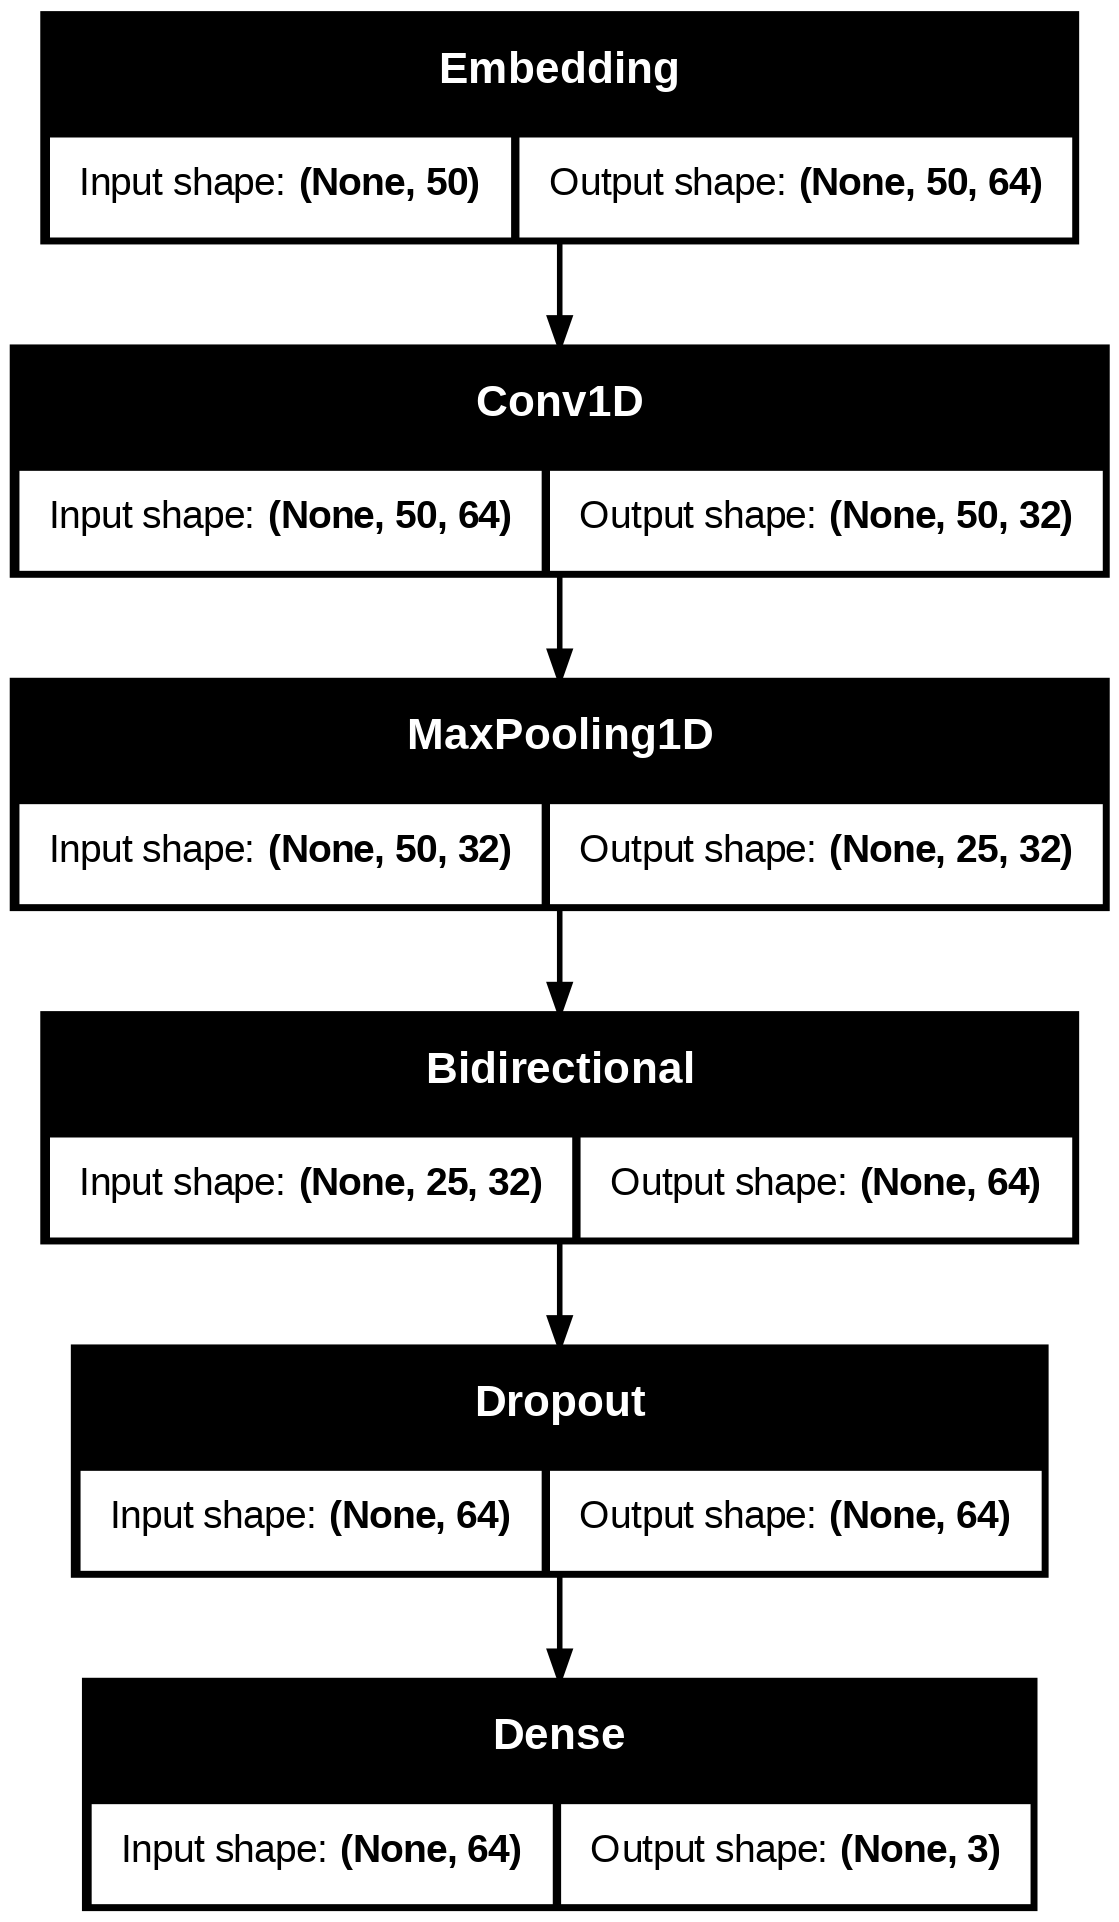

In [39]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot to class labels for computing class weights
y_labels = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.array([0, 1, 2]),
                                     y=y_labels)
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    class_weight=class_weight_dict,
                    callbacks=[reduce_lr, early_stop])


Epoch 1/17
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7541 - loss: 0.5584 - precision_1: 0.8299 - recall_1: 0.6614 - val_accuracy: 0.9450 - val_loss: 0.2069 - val_precision_1: 0.9464 - val_recall_1: 0.9440 - learning_rate: 0.0010
Epoch 2/17
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9476 - loss: 0.2047 - precision_1: 0.9495 - recall_1: 0.9455 - val_accuracy: 0.9451 - val_loss: 0.2007 - val_precision_1: 0.9464 - val_recall_1: 0.9438 - learning_rate: 0.0010
Epoch 3/17
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9566 - loss: 0.1705 - precision_1: 0.9592 - recall_1: 0.9545 - val_accuracy: 0.9459 - val_loss: 0.1982 - val_precision_1: 0.9473 - val_recall_1: 0.9445 - learning_rate: 0.0010
Epoch 4/17
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9636 - loss: 0.1406 - precision_1: 0.9658 - recall_1: 0.9613 - val_accuracy: 0.9356 - val_loss: 0.2319 - val_precision_1: 0.9381 - val_recall_1: 0.9335 - learning_rate: 0.0010
Epoch 5/17
1528/1528

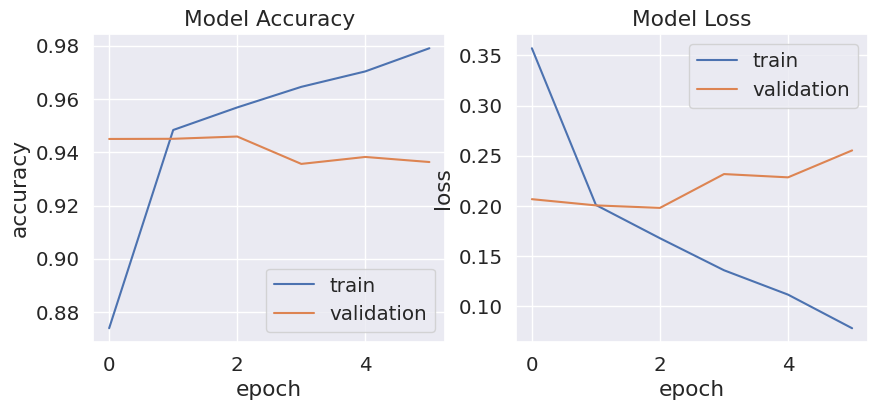

In [41]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [42]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9455
Precision : 0.9468
Recall    : 0.9441
F1 Score  : 0.9454


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


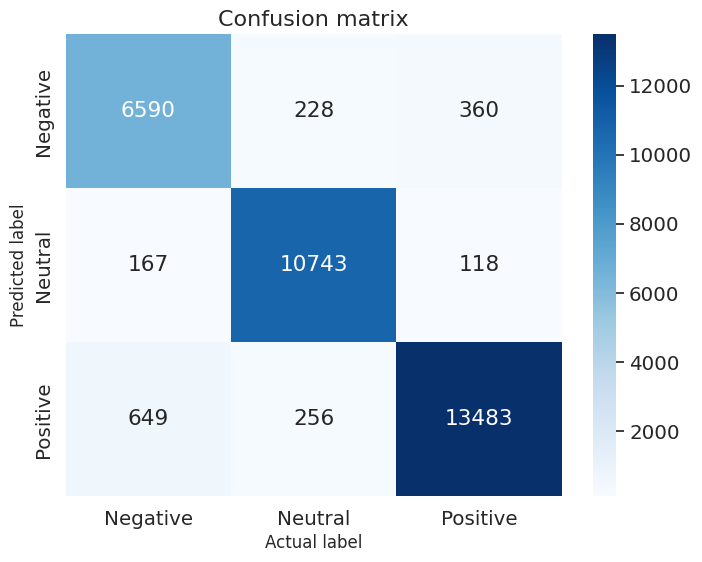

In [43]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [44]:
model.save('/kaggle/working/analysismodel.h5')
print("DONE")

DONE


In [45]:
from keras.models import load_model

# Load model
model1 = load_model('/kaggle/working/analysismodel.h5')

In [46]:
def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print(sentiment_classes[yt[0]])

In [47]:
predict_class(["I ordered food online, and it arrived on time."])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Neutral


In [48]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 50, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 25, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,013 (1.31 MB)

 Trainable params: 343,011 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [49]:
comments = [
    "I absolutely love this place!",
    "This product is terrible, very disappointing.",
    "It was an okay experience, not too great but not bad either.",
    "The food was amazing! Highly recommend this restaurant.",
    "I can't believe how bad the service was, I'm never coming back!",
    "I'm not sure if I like it or not. It's decent but could be better.",
    "What a beautiful view, I could spend all day here!",
    "I hate waiting in long lines, it's so frustrating.",
    "The video was recorded",
    "I absolutely adore this movie, such a masterpiece!",
    "This video was uploaded on Monday."
]

for comment in comments:
    predict_class([comment])  # Ensure your predict_class function is defined as previously

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Neutral
